# Machine Learning Project

## Introduction

The goal of the project is to recognize if the image is a face or not.

Images are greyscale 36x36 pixels images.

To reach the goal, we will try to train a convolutional neural network.

In [1]:
from deep_learning_project.load_data import basic_load, imbalanced_load, get_transform
from deep_learning_project.net import FirstNeuralNetwork, LinearRegressionNetwork, SecondNeuralNetwork
from deep_learning_project.torchsampler import ImbalancedDatasetSampler
import torch
import matplotlib.pyplot as plt
from torch import nn
from deep_learning_project.trainers import BaseTrainer
from torchvision.transforms import InterpolationMode
import torchvision
import os
import json
import datetime
import torchvision.transforms as T
from tqdm import tqdm
from deep_learning_project.utils import Exporter
import cv2 as cv
from cv2 import IMREAD_GRAYSCALE, IMREAD_COLOR
import math
import numpy as np

CURRENT_FOLDER = '.'
MODEL_FOLDERS = os.path.join(CURRENT_FOLDER, 'models')

c:\python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def predict(model, img):
    obj = None
    with torch.no_grad():
        # exploit the model
        logits = model(img)
        pred_probab = nn.Softmax(dim=1)(logits)
        y_pred = pred_probab.argmax(1).item() # indice(s) of the maximum value in the tensor
        obj = (y_pred, pred_probab)
    return obj

def load_background_images():
    TEXTURE_FOLDER = os.path.abspath('./deep_learning_project/textures/')

    onlyfiles = [f for f in os.listdir(TEXTURE_FOLDER) if os.path.isfile(os.path.join(TEXTURE_FOLDER, f))]

    img_datas = []

    for filename in onlyfiles:
        img_src = cv.samples.findFile(os.path.join(TEXTURE_FOLDER, filename))
        img_datas.append(cv.imread(img_src, IMREAD_COLOR))
    
    return img_datas

def gather_false_positive(model, background_images, rescale=0.8, threshold=0.8, stride=1, device='cpu'):
    images = [] # this array will contain false positives images

    for image in background_images:
        transform = get_transform()
        transformed_image = transform(T.ToPILImage()(image))

        while (True):
            for y in range(0, transformed_image.size()[1] - 36, stride):
                for x in range(0, transformed_image.size()[2] - 36, stride):

                    # crop and preparing the cropped image
                    new_img = transformed_image[:, y:y+36, x:x+36]
                    torch_new_img = new_img.reshape((1, 1, 36, 36))

                    (y_pred, pred_probab) = predict(model, torch_new_img.to(device))
                    
                    # 0 = noface, 1 = face
                    if pred_probab.squeeze()[1] >= threshold:
                        images.append(new_img.reshape(36, 36))

            new_height = math.ceil(transformed_image.size()[1] * rescale)
            new_width = math.ceil(transformed_image.size()[2] * rescale)

            # stop the loop if the image is smaller than the retina
            if new_height < 36 or new_width < 36:
                break

            transformed_image = T.Resize((new_height, new_width), interpolation=InterpolationMode.BILINEAR)(transformed_image)
    
    images = torch.stack(images)
    images = images.reshape(images.size()[0], 1, 36, 36).permute((0, 2, 3, 1)).numpy()
    return images

TEXTURE_FP_FOLDER = os.path.abspath('./deep_learning_project/texturesfp/')
def save_images(dir_path, images):
    dir_path = os.path.join(dir_path, '0')
    os.makedirs(dir_path, exist_ok=True)

    offset = len(os.listdir(dir_path))

    for i, img in enumerate(images):
        filename = str(offset + i) + ".pgm"
        cv.imwrite(os.path.join(dir_path, filename), img)

def delete_files_in_dir(dir_path):
    onlyfiles = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]
    for file in onlyfiles:
        os.remove(os.path.join(dir_path, file))

In [3]:
epochs=20
learning_rate=0.001
momentum=0.90
weight_decay=0
valid_size=0.2
batch_size=64

## Data

Data is separated in 3 datasets.

Train : to train the ML model.

Valid : to valid the ML model.

Test : to test the ML model.

What is the difference between valid and test datasets. The main differencec is when there are used : valid are used inside the training process but test are used when the training is complete. Why use different datasets to do the same thing (test the generalization of model) ? Some do the validation with the test dataset but it is not scientifically correct because it will include a bias on the model. If we train the model until the test dataset error is the lowest, we effectively train the model for the test dataset... This is why we use two different dataset.

In [4]:
device = "cpu"
parallel = False

if torch.cuda.is_available():
    device = "cuda:0"
    if torch.cuda.device_count() > 1:
        parallel = True

print(f"Running on {device}. Parallel={parallel}.")

data = imbalanced_load(valid_size=valid_size, batch_size=batch_size, device=device)
train_loader = data[0]
valid_loader = data[1]
test_loader = data[2]
classes = data[3]
train_data = data[4]
train_idx = data[5]

background_images = load_background_images()

Running on cuda:0. Parallel=False.


Feature batch shape: torch.Size([64, 1, 36, 36])
Labels batch shape: torch.Size([64])


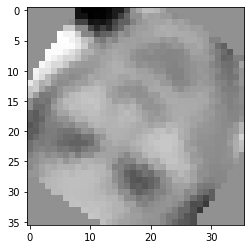

Label: 1


In [5]:
train_features, train_labels = next(iter(data[0]))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze() # from 2d to 1d, works only when the data is 1d [[x]] => [x]
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()

print(f"Label: {label}")

Printing one image of the training set.


## Initializing the FirstNeuralNetwork network

We initialize the network.

Print the configuration.

Then predict a random input.

---

FirstNeuralNetwork is the neural network given by the teacher.

In [6]:
loss_fn = nn.CrossEntropyLoss()

model = SecondNeuralNetwork()
if parallel:
    model = nn.DataParallel(model)
model.to(device)

SecondNeuralNetwork(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=4800, out_features=48, bias=True)
  (fc2): Linear(in_features=48, out_features=24, bias=True)
  (fc3): Linear(in_features=24, out_features=2, bias=True)
)

In [7]:
random_shit = torch.rand((1, 1, 36, 36), device=device)

logits = model(random_shit)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([0], device='cuda:0')


## Optimizing the network

In [8]:
exporter = Exporter()
exporter.prepare_export(MODEL_FOLDERS, str(model.__class__.__name__))

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
trainer = BaseTrainer(model, loss_fn, optimizer, checkpoints_path=exporter.folder)

In [10]:
%%time

trainer.fit(train_loader=train_loader,
            valid_loader=valid_loader,
            test_loader=test_loader,
            epochs=epochs,
            device=device)

Size of train dataset=73376, train batches=1147, valid dataset=18344, valid batches=287, test dataset=7628, test batches=120


1147it [00:41, 27.58it/s]


epoch 1 of 20 : train_loss: 0.16236, train_accuracy: 93.15%, valid_loss: 0.07524, valid_accuracy: 97.31%, test_loss: 0.06970, test_accuracy: 97.51%


1147it [01:07, 16.87it/s]


epoch 2 of 20 : train_loss: 0.06060, train_accuracy: 97.78%, valid_loss: 0.05467, valid_accuracy: 97.99%, test_loss: 0.06010, test_accuracy: 98.01%


1147it [00:37, 30.44it/s]


epoch 3 of 20 : train_loss: 0.04782, train_accuracy: 98.29%, valid_loss: 0.03415, valid_accuracy: 98.77%, test_loss: 0.09591, test_accuracy: 96.39%


1147it [00:27, 41.47it/s]


epoch 4 of 20 : train_loss: 0.03855, train_accuracy: 98.65%, valid_loss: 0.02981, valid_accuracy: 98.99%, test_loss: 0.08396, test_accuracy: 97.13%


1147it [00:23, 48.22it/s]


epoch 5 of 20 : train_loss: 0.03488, train_accuracy: 98.80%, valid_loss: 0.02385, valid_accuracy: 99.14%, test_loss: 0.09640, test_accuracy: 96.85%


1147it [00:22, 51.93it/s]


epoch 6 of 20 : train_loss: 0.02880, train_accuracy: 99.00%, valid_loss: 0.02764, valid_accuracy: 99.02%, test_loss: 0.06683, test_accuracy: 97.63%


1147it [00:20, 56.19it/s]


epoch 7 of 20 : train_loss: 0.02880, train_accuracy: 98.99%, valid_loss: 0.02765, valid_accuracy: 98.93%, test_loss: 0.09642, test_accuracy: 96.46%


1147it [00:19, 58.21it/s]


epoch 8 of 20 : train_loss: 0.02630, train_accuracy: 99.07%, valid_loss: 0.02994, valid_accuracy: 99.02%, test_loss: 0.06567, test_accuracy: 97.56%


1147it [00:19, 57.58it/s]


epoch 9 of 20 : train_loss: 0.02417, train_accuracy: 99.17%, valid_loss: 0.02099, valid_accuracy: 99.27%, test_loss: 0.07694, test_accuracy: 97.25%


1147it [00:19, 59.08it/s]


epoch 10 of 20 : train_loss: 0.02375, train_accuracy: 99.17%, valid_loss: 0.02007, valid_accuracy: 99.31%, test_loss: 0.07193, test_accuracy: 97.47%


1147it [00:19, 58.52it/s]


epoch 11 of 20 : train_loss: 0.02189, train_accuracy: 99.24%, valid_loss: 0.02000, valid_accuracy: 99.33%, test_loss: 0.08169, test_accuracy: 97.12%


1147it [00:19, 58.08it/s]


epoch 12 of 20 : train_loss: 0.01980, train_accuracy: 99.31%, valid_loss: 0.02190, valid_accuracy: 99.28%, test_loss: 0.10162, test_accuracy: 96.75%


1147it [00:20, 57.00it/s]


epoch 13 of 20 : train_loss: 0.01895, train_accuracy: 99.32%, valid_loss: 0.01685, valid_accuracy: 99.46%, test_loss: 0.11225, test_accuracy: 95.96%


1147it [00:19, 58.99it/s]


epoch 14 of 20 : train_loss: 0.01884, train_accuracy: 99.36%, valid_loss: 0.01571, valid_accuracy: 99.47%, test_loss: 0.10105, test_accuracy: 96.85%


1147it [00:19, 57.39it/s]


epoch 15 of 20 : train_loss: 0.01793, train_accuracy: 99.38%, valid_loss: 0.02097, valid_accuracy: 99.22%, test_loss: 0.10066, test_accuracy: 96.37%


1147it [00:19, 58.85it/s]


epoch 16 of 20 : train_loss: 0.01688, train_accuracy: 99.44%, valid_loss: 0.01622, valid_accuracy: 99.37%, test_loss: 0.12589, test_accuracy: 95.99%


1147it [00:19, 59.37it/s]


epoch 17 of 20 : train_loss: 0.01514, train_accuracy: 99.47%, valid_loss: 0.02386, valid_accuracy: 99.14%, test_loss: 0.09923, test_accuracy: 96.89%


1147it [00:19, 59.45it/s]


epoch 18 of 20 : train_loss: 0.01726, train_accuracy: 99.43%, valid_loss: 0.01489, valid_accuracy: 99.53%, test_loss: 0.11432, test_accuracy: 96.53%


1147it [00:19, 59.46it/s]


epoch 19 of 20 : train_loss: 0.01520, train_accuracy: 99.48%, valid_loss: 0.01440, valid_accuracy: 99.42%, test_loss: 0.11993, test_accuracy: 95.60%


1147it [00:19, 58.60it/s]


epoch 20 of 20 : train_loss: 0.01385, train_accuracy: 99.51%, valid_loss: 0.01388, valid_accuracy: 99.56%, test_loss: 0.16061, test_accuracy: 96.05%
CPU times: total: 3min 17s
Wall time: 17min 32s


In [11]:
delete_files_in_dir(TEXTURE_FP_FOLDER)

for threshold in [0.8, 0.6, 0.4, 0.2, 0]:
    fp_images = gather_false_positive(
        model,
        background_images,
        rescale=0.8,
        stride=100,
        threshold=threshold,
        device=device)
    

    save_images(TEXTURE_FP_FOLDER, fp_images)

    fp_data = torchvision.datasets.ImageFolder(TEXTURE_FP_FOLDER, transform=get_transform())
    
    indices = [idx for idx, target in enumerate(train_data.targets) if target == 1]
    indices = [idx for idx in indices if idx in train_idx]
    np.random.shuffle(indices)

    if len(fp_data) < len(indices):
        indices = indices[:len(fp_data)]
    
    face_imgs = torch.utils.data.Subset(train_data, indices)

    both_data = torch.utils.data.ConcatDataset([face_imgs, fp_data])
    both_sampler = ImbalancedDatasetSampler(both_data, callback_get_label=(lambda x, y: x[y][1]))

    kwargs = {'num_workers': 4, 'pin_memory': True} if 'cuda' in device else {}
    loader = torch.utils.data.DataLoader(both_data, batch_size=batch_size, sampler=both_sampler, **kwargs)
    
    trainer.fit(train_loader=loader,
            valid_loader=valid_loader,
            test_loader=test_loader,
            epochs=epochs,
            device=device)

fullset = torchvision.datasets.ImageFolder(TEXTURE_FP_FOLDER, transform=get_transform())
both_data_full = torch.utils.data.ConcatDataset([torch.utils.data.Subset(train_data, train_idx), fp_data])
full_both_sampler = ImbalancedDatasetSampler(both_data_full, callback_get_label=(lambda x, y: x[y][1]))
kwargs = {'num_workers': 4, 'pin_memory': True} if 'cuda' in device else {}
full_loader = torch.utils.data.DataLoader(both_data_full, batch_size=batch_size, sampler=full_both_sampler, **kwargs)

trainer.fit(train_loader=full_loader,
            valid_loader=valid_loader,
            test_loader=test_loader,
            epochs=epochs,
            device=device)

Size of train dataset=195805, train batches=3060, valid dataset=18344, valid batches=287, test dataset=7628, test batches=120


3060it [01:13, 41.77it/s]


epoch 1 of 20 : train_loss: 0.00003, train_accuracy: 100.00%, valid_loss: 0.63760, valid_accuracy: 91.16%, test_loss: 1.34211, test_accuracy: 76.90%


3060it [00:52, 58.13it/s]


epoch 2 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 2.11087, valid_accuracy: 83.41%, test_loss: 3.19431, test_accuracy: 63.74%


3060it [00:45, 66.57it/s]


epoch 3 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 2.13463, valid_accuracy: 83.49%, test_loss: 3.45902, test_accuracy: 61.08%


3060it [00:42, 71.39it/s]


epoch 4 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 2.13387, valid_accuracy: 83.30%, test_loss: 3.44127, test_accuracy: 61.37%


3060it [01:17, 39.68it/s]


epoch 5 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 2.51587, valid_accuracy: 82.17%, test_loss: 4.11479, test_accuracy: 57.62%


3060it [01:42, 29.83it/s]


epoch 6 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 3.05127, valid_accuracy: 80.88%, test_loss: 5.45133, test_accuracy: 51.31%


3060it [01:02, 49.13it/s]


epoch 7 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 3.34502, valid_accuracy: 80.27%, test_loss: 5.94507, test_accuracy: 50.05%


3060it [00:49, 62.07it/s]


epoch 8 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 3.33724, valid_accuracy: 80.34%, test_loss: 6.04355, test_accuracy: 49.92%


3060it [00:45, 67.61it/s]


epoch 9 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 3.34015, valid_accuracy: 80.48%, test_loss: 6.06013, test_accuracy: 50.05%


3060it [00:42, 72.57it/s]


epoch 10 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 3.34736, valid_accuracy: 80.73%, test_loss: 6.00743, test_accuracy: 50.13%


3060it [00:40, 75.93it/s]


epoch 11 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 3.46887, valid_accuracy: 80.65%, test_loss: 6.71090, test_accuracy: 47.40%


3060it [02:12, 23.02it/s]


epoch 12 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 3.47944, valid_accuracy: 80.41%, test_loss: 6.95688, test_accuracy: 46.91%


3060it [01:51, 27.41it/s]


epoch 13 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 3.56214, valid_accuracy: 80.34%, test_loss: 6.92150, test_accuracy: 46.89%


3060it [01:33, 32.75it/s]


epoch 14 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 3.49452, valid_accuracy: 80.41%, test_loss: 6.92393, test_accuracy: 46.85%


3060it [00:59, 51.30it/s]


epoch 15 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 3.51241, valid_accuracy: 80.57%, test_loss: 6.94046, test_accuracy: 46.81%


3060it [00:50, 61.18it/s]


epoch 16 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 144.68279, valid_accuracy: 70.72%, test_loss: 383.26017, test_accuracy: 12.24%


3060it [01:39, 30.83it/s]


epoch 17 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.80650, valid_accuracy: 70.66%, test_loss: 392.77325, test_accuracy: 12.18%


3060it [01:30, 33.91it/s]


epoch 18 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.73305, valid_accuracy: 70.66%, test_loss: 393.51541, test_accuracy: 12.18%


3060it [01:00, 50.87it/s]


epoch 19 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.24256, valid_accuracy: 70.66%, test_loss: 393.41110, test_accuracy: 12.19%


3060it [00:48, 63.01it/s]


epoch 20 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.45082, valid_accuracy: 70.66%, test_loss: 393.16944, test_accuracy: 12.21%
Size of train dataset=335585, train batches=5244, valid dataset=18344, valid batches=287, test dataset=7628, test batches=120


5244it [03:17, 26.61it/s]


epoch 1 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.23338, valid_accuracy: 70.66%, test_loss: 392.92769, test_accuracy: 12.22%


5244it [03:13, 27.07it/s]


epoch 2 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.39171, valid_accuracy: 70.66%, test_loss: 392.69723, test_accuracy: 12.23%


5244it [03:24, 25.68it/s]


epoch 3 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.39499, valid_accuracy: 70.66%, test_loss: 392.73032, test_accuracy: 12.23%


5244it [03:21, 26.01it/s]


epoch 4 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.37186, valid_accuracy: 70.66%, test_loss: 393.72810, test_accuracy: 12.23%


5244it [03:10, 27.57it/s]


epoch 5 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.10916, valid_accuracy: 70.65%, test_loss: 393.30049, test_accuracy: 12.24%


5244it [02:45, 31.70it/s]


epoch 6 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.42508, valid_accuracy: 70.65%, test_loss: 393.91470, test_accuracy: 12.24%


5244it [02:55, 29.95it/s]


epoch 7 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 159.11153, valid_accuracy: 70.65%, test_loss: 392.74813, test_accuracy: 12.24%


5244it [03:20, 26.11it/s]


epoch 8 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.34923, valid_accuracy: 70.66%, test_loss: 392.76079, test_accuracy: 12.24%


5244it [03:15, 26.79it/s]


epoch 9 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.60407, valid_accuracy: 70.66%, test_loss: 392.67550, test_accuracy: 12.24%


5244it [03:06, 28.16it/s]


epoch 10 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.32620, valid_accuracy: 70.66%, test_loss: 392.79135, test_accuracy: 12.24%


5244it [03:01, 28.88it/s]


epoch 11 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.34069, valid_accuracy: 70.66%, test_loss: 392.92753, test_accuracy: 12.24%


5244it [02:46, 31.44it/s]


epoch 12 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.35735, valid_accuracy: 70.65%, test_loss: 392.81372, test_accuracy: 12.24%


5244it [03:20, 26.15it/s]


epoch 13 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.54545, valid_accuracy: 70.66%, test_loss: 393.25184, test_accuracy: 12.24%


5244it [03:16, 26.63it/s]


epoch 14 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 159.02219, valid_accuracy: 70.66%, test_loss: 393.28812, test_accuracy: 12.24%


5244it [03:16, 26.66it/s]


epoch 15 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.42589, valid_accuracy: 70.66%, test_loss: 392.80183, test_accuracy: 12.24%


5244it [03:01, 28.95it/s]


epoch 16 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 157.63268, valid_accuracy: 70.65%, test_loss: 392.81343, test_accuracy: 12.24%


5244it [02:55, 29.89it/s]


epoch 17 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.50897, valid_accuracy: 70.66%, test_loss: 393.06793, test_accuracy: 12.24%


5244it [03:46, 23.15it/s]


epoch 18 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 157.95842, valid_accuracy: 70.66%, test_loss: 392.86565, test_accuracy: 12.24%


5244it [03:10, 27.58it/s]


epoch 19 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.56738, valid_accuracy: 70.66%, test_loss: 392.67257, test_accuracy: 12.24%


5244it [03:07, 27.97it/s]


epoch 20 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.61156, valid_accuracy: 70.65%, test_loss: 392.34297, test_accuracy: 12.24%
Size of train dataset=475367, train batches=7428, valid dataset=18344, valid batches=287, test dataset=7628, test batches=120


7428it [04:58, 24.91it/s]


epoch 1 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.27687, valid_accuracy: 70.66%, test_loss: 392.83852, test_accuracy: 12.24%


7428it [04:33, 27.15it/s]


epoch 2 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.64856, valid_accuracy: 70.66%, test_loss: 392.58663, test_accuracy: 12.24%


7428it [05:31, 22.41it/s]


epoch 3 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.59689, valid_accuracy: 70.66%, test_loss: 392.29465, test_accuracy: 12.24%


7428it [05:28, 22.58it/s]


epoch 4 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.28348, valid_accuracy: 70.66%, test_loss: 393.05816, test_accuracy: 12.24%


7428it [05:28, 22.62it/s]


epoch 5 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.65677, valid_accuracy: 70.66%, test_loss: 393.52442, test_accuracy: 12.24%


7428it [04:44, 26.09it/s]


epoch 6 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.54952, valid_accuracy: 70.66%, test_loss: 392.72250, test_accuracy: 12.24%


7428it [05:04, 24.37it/s]


epoch 7 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.50873, valid_accuracy: 70.66%, test_loss: 392.27768, test_accuracy: 12.24%


7428it [04:41, 26.38it/s]


epoch 8 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.37748, valid_accuracy: 70.66%, test_loss: 391.94830, test_accuracy: 12.24%


7428it [04:34, 27.06it/s]


epoch 9 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.62776, valid_accuracy: 70.65%, test_loss: 392.68677, test_accuracy: 12.24%


7428it [05:28, 22.62it/s]


epoch 10 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.89450, valid_accuracy: 70.66%, test_loss: 392.69345, test_accuracy: 12.24%


7428it [05:23, 22.98it/s]


epoch 11 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 159.21486, valid_accuracy: 70.66%, test_loss: 392.74751, test_accuracy: 12.24%


7428it [04:36, 26.84it/s]


epoch 12 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.48052, valid_accuracy: 70.66%, test_loss: 392.40175, test_accuracy: 12.24%


7428it [05:23, 22.95it/s]


epoch 13 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.42419, valid_accuracy: 70.66%, test_loss: 392.65938, test_accuracy: 12.24%


7428it [04:39, 26.59it/s]


epoch 14 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.15101, valid_accuracy: 70.65%, test_loss: 393.18509, test_accuracy: 12.24%


7428it [06:06, 20.29it/s]


epoch 15 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.60505, valid_accuracy: 70.65%, test_loss: 393.67889, test_accuracy: 12.24%


7428it [04:48, 25.73it/s]


epoch 16 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.51246, valid_accuracy: 70.65%, test_loss: 392.62509, test_accuracy: 12.24%


7428it [05:21, 23.11it/s]


epoch 17 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.11372, valid_accuracy: 70.66%, test_loss: 392.56572, test_accuracy: 12.24%


7428it [04:46, 25.94it/s]


epoch 18 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.74577, valid_accuracy: 70.66%, test_loss: 391.83162, test_accuracy: 12.24%


7428it [04:35, 26.97it/s]


epoch 19 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.81004, valid_accuracy: 70.66%, test_loss: 391.58018, test_accuracy: 12.24%


7428it [05:06, 24.23it/s]


epoch 20 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.81099, valid_accuracy: 70.66%, test_loss: 392.46203, test_accuracy: 12.24%
Size of train dataset=615223, train batches=9613, valid dataset=18344, valid batches=287, test dataset=7628, test batches=120


9613it [08:36, 18.61it/s]


epoch 1 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.53976, valid_accuracy: 70.65%, test_loss: 392.77608, test_accuracy: 12.24%


9613it [09:53, 16.20it/s]


epoch 2 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.96066, valid_accuracy: 70.66%, test_loss: 393.09574, test_accuracy: 12.24%


9613it [09:18, 17.21it/s]


epoch 3 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.36560, valid_accuracy: 70.66%, test_loss: 392.02289, test_accuracy: 12.24%


9613it [09:05, 17.63it/s]


epoch 4 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.64411, valid_accuracy: 70.66%, test_loss: 392.36266, test_accuracy: 12.24%


9613it [07:33, 21.20it/s]


epoch 5 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.40548, valid_accuracy: 70.66%, test_loss: 392.50762, test_accuracy: 12.24%


9613it [06:35, 24.33it/s]


epoch 6 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.50017, valid_accuracy: 70.66%, test_loss: 392.33979, test_accuracy: 12.24%


9613it [07:41, 20.85it/s]


epoch 7 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 159.33731, valid_accuracy: 70.66%, test_loss: 392.84087, test_accuracy: 12.24%


9613it [07:21, 21.76it/s]


epoch 8 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.48568, valid_accuracy: 70.65%, test_loss: 393.21194, test_accuracy: 12.24%


9613it [07:44, 20.70it/s]


epoch 9 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.10168, valid_accuracy: 70.66%, test_loss: 392.48807, test_accuracy: 12.24%


9613it [08:48, 18.19it/s]


epoch 10 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 159.11147, valid_accuracy: 70.66%, test_loss: 392.78498, test_accuracy: 12.24%


9613it [09:02, 17.73it/s]


epoch 11 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.28110, valid_accuracy: 70.65%, test_loss: 392.90349, test_accuracy: 12.24%


9613it [08:46, 18.27it/s]


epoch 12 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.62530, valid_accuracy: 70.66%, test_loss: 393.39551, test_accuracy: 12.24%


9613it [08:32, 18.77it/s]


epoch 13 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.23715, valid_accuracy: 70.65%, test_loss: 392.34975, test_accuracy: 12.24%


9613it [07:33, 21.20it/s]


epoch 14 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.56884, valid_accuracy: 70.66%, test_loss: 392.16759, test_accuracy: 12.24%


9613it [07:08, 22.42it/s]


epoch 15 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.32480, valid_accuracy: 70.66%, test_loss: 392.13978, test_accuracy: 12.24%


9613it [07:02, 22.74it/s]


epoch 16 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.21887, valid_accuracy: 70.66%, test_loss: 392.97182, test_accuracy: 12.24%


9613it [06:59, 22.90it/s]


epoch 17 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.44075, valid_accuracy: 70.65%, test_loss: 392.71267, test_accuracy: 12.24%


9613it [07:05, 22.57it/s]


epoch 18 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.69745, valid_accuracy: 70.65%, test_loss: 392.82443, test_accuracy: 12.24%


9613it [07:04, 22.64it/s]


epoch 19 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.14025, valid_accuracy: 70.66%, test_loss: 392.75801, test_accuracy: 12.24%


9613it [07:08, 22.42it/s]


epoch 20 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 159.18084, valid_accuracy: 70.65%, test_loss: 392.45943, test_accuracy: 12.24%
Size of train dataset=760472, train batches=11883, valid dataset=18344, valid batches=287, test dataset=7628, test batches=120


11883it [09:38, 20.55it/s]


epoch 1 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 157.95810, valid_accuracy: 70.66%, test_loss: 392.49668, test_accuracy: 12.24%


11883it [09:25, 21.01it/s]


epoch 2 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.92534, valid_accuracy: 70.66%, test_loss: 392.58521, test_accuracy: 12.24%


11883it [09:14, 21.44it/s]


epoch 3 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.73973, valid_accuracy: 70.66%, test_loss: 393.33653, test_accuracy: 12.24%


11883it [09:28, 20.90it/s]


epoch 4 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.46577, valid_accuracy: 70.66%, test_loss: 392.77909, test_accuracy: 12.24%


11883it [09:04, 21.83it/s]


epoch 5 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.18061, valid_accuracy: 70.66%, test_loss: 392.98595, test_accuracy: 12.24%


11883it [08:45, 22.63it/s]


epoch 6 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 157.96463, valid_accuracy: 70.66%, test_loss: 392.22682, test_accuracy: 12.24%


11883it [09:52, 20.04it/s]


epoch 7 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.47570, valid_accuracy: 70.65%, test_loss: 392.32330, test_accuracy: 12.24%


11883it [10:38, 18.63it/s]


epoch 8 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.42226, valid_accuracy: 70.66%, test_loss: 392.87968, test_accuracy: 12.24%


11883it [11:23, 17.38it/s]


epoch 9 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.26447, valid_accuracy: 70.66%, test_loss: 392.12899, test_accuracy: 12.24%


11883it [10:57, 18.06it/s]


epoch 10 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.25261, valid_accuracy: 70.66%, test_loss: 393.00477, test_accuracy: 12.24%


11883it [10:06, 19.58it/s]


epoch 11 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 159.24415, valid_accuracy: 70.66%, test_loss: 393.35432, test_accuracy: 12.24%


11883it [09:39, 20.51it/s]


epoch 12 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.57383, valid_accuracy: 70.65%, test_loss: 392.30747, test_accuracy: 12.24%


11883it [08:43, 22.72it/s]


epoch 13 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.27139, valid_accuracy: 70.66%, test_loss: 393.32898, test_accuracy: 12.24%


11883it [09:06, 21.73it/s]


epoch 14 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.36866, valid_accuracy: 70.66%, test_loss: 393.25309, test_accuracy: 12.24%


11883it [08:34, 23.11it/s]


epoch 15 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 157.88046, valid_accuracy: 70.66%, test_loss: 392.28591, test_accuracy: 12.24%


11883it [09:08, 21.68it/s]


epoch 16 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.41341, valid_accuracy: 70.66%, test_loss: 392.68180, test_accuracy: 12.24%


11883it [08:57, 22.11it/s]


epoch 17 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.39986, valid_accuracy: 70.66%, test_loss: 393.21297, test_accuracy: 12.24%


11883it [09:33, 20.71it/s]


epoch 18 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.89906, valid_accuracy: 70.66%, test_loss: 392.60925, test_accuracy: 12.24%


11883it [08:35, 23.07it/s]


epoch 19 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.48105, valid_accuracy: 70.66%, test_loss: 392.25140, test_accuracy: 12.24%


11883it [09:35, 20.64it/s]


epoch 20 of 20 : train_loss: 0.00000, train_accuracy: 100.00%, valid_loss: 158.21851, valid_accuracy: 70.66%, test_loss: 392.54894, test_accuracy: 12.24%
Size of train dataset=782038, train batches=12220, valid dataset=18344, valid batches=287, test dataset=7628, test batches=120


12220it [09:45, 20.87it/s]


epoch 1 of 20 : train_loss: 0.00976, train_accuracy: 99.77%, valid_loss: 0.05742, valid_accuracy: 98.08%, test_loss: 0.17511, test_accuracy: 94.17%


12220it [09:15, 22.01it/s]


epoch 2 of 20 : train_loss: 0.00688, train_accuracy: 99.79%, valid_loss: 0.12721, valid_accuracy: 96.61%, test_loss: 0.33939, test_accuracy: 91.57%


12220it [09:55, 20.51it/s]


epoch 3 of 20 : train_loss: 0.00691, train_accuracy: 99.78%, valid_loss: 0.10400, valid_accuracy: 96.86%, test_loss: 0.21232, test_accuracy: 93.64%


12220it [09:30, 21.42it/s]


epoch 4 of 20 : train_loss: 0.00718, train_accuracy: 99.78%, valid_loss: 0.03156, valid_accuracy: 99.01%, test_loss: 0.16693, test_accuracy: 94.72%


12220it [09:17, 21.92it/s]


epoch 5 of 20 : train_loss: 0.01025, train_accuracy: 99.75%, valid_loss: 0.03006, valid_accuracy: 98.95%, test_loss: 0.16165, test_accuracy: 95.74%


12220it [09:57, 20.44it/s]


epoch 6 of 20 : train_loss: 0.00638, train_accuracy: 99.81%, valid_loss: 0.16809, valid_accuracy: 97.17%, test_loss: 0.55655, test_accuracy: 90.53%


12220it [09:35, 21.24it/s]


epoch 7 of 20 : train_loss: 0.00740, train_accuracy: 99.78%, valid_loss: 0.02704, valid_accuracy: 99.04%, test_loss: 0.17479, test_accuracy: 95.62%


12220it [09:23, 21.68it/s]


epoch 8 of 20 : train_loss: 0.00737, train_accuracy: 99.80%, valid_loss: 0.05014, valid_accuracy: 99.05%, test_loss: 0.18307, test_accuracy: 96.22%


12220it [09:26, 21.59it/s]


epoch 9 of 20 : train_loss: 0.00764, train_accuracy: 99.79%, valid_loss: 0.03927, valid_accuracy: 99.20%, test_loss: 0.21381, test_accuracy: 96.70%


12220it [10:36, 19.21it/s]


epoch 10 of 20 : train_loss: 0.00844, train_accuracy: 99.79%, valid_loss: 0.04046, valid_accuracy: 99.22%, test_loss: 0.25265, test_accuracy: 95.66%


12220it [10:50, 18.78it/s]


epoch 11 of 20 : train_loss: 0.00758, train_accuracy: 99.82%, valid_loss: 0.07827, valid_accuracy: 97.90%, test_loss: 0.21290, test_accuracy: 94.38%


12220it [11:57, 17.02it/s]


epoch 12 of 20 : train_loss: 0.01122, train_accuracy: 99.77%, valid_loss: 0.04853, valid_accuracy: 98.72%, test_loss: 0.15346, test_accuracy: 96.43%


12220it [11:36, 17.55it/s]


epoch 13 of 20 : train_loss: 0.01281, train_accuracy: 99.79%, valid_loss: 0.09353, valid_accuracy: 98.12%, test_loss: 0.23538, test_accuracy: 96.39%


12220it [10:54, 18.67it/s]


epoch 14 of 20 : train_loss: 0.00838, train_accuracy: 99.82%, valid_loss: 0.13413, valid_accuracy: 97.45%, test_loss: 0.43336, test_accuracy: 92.87%


12220it [10:53, 18.70it/s]


epoch 15 of 20 : train_loss: 0.00677, train_accuracy: 99.83%, valid_loss: 0.03546, valid_accuracy: 99.22%, test_loss: 0.38758, test_accuracy: 96.60%


12220it [11:17, 18.03it/s]


epoch 16 of 20 : train_loss: 0.00745, train_accuracy: 99.85%, valid_loss: 0.05893, valid_accuracy: 98.31%, test_loss: 0.18645, test_accuracy: 94.89%


12220it [11:49, 17.21it/s]


epoch 17 of 20 : train_loss: 0.00845, train_accuracy: 99.84%, valid_loss: 0.05677, valid_accuracy: 98.92%, test_loss: 0.26155, test_accuracy: 95.84%


12220it [11:47, 17.28it/s]


epoch 18 of 20 : train_loss: 0.01011, train_accuracy: 99.82%, valid_loss: 0.13884, valid_accuracy: 97.68%, test_loss: 0.30848, test_accuracy: 95.98%


12220it [12:23, 16.45it/s]


epoch 19 of 20 : train_loss: 0.00607, train_accuracy: 99.85%, valid_loss: 0.07529, valid_accuracy: 98.41%, test_loss: 0.15103, test_accuracy: 97.12%


12220it [10:39, 19.11it/s]


epoch 20 of 20 : train_loss: 0.00816, train_accuracy: 99.82%, valid_loss: 0.03437, valid_accuracy: 99.13%, test_loss: 0.29796, test_accuracy: 95.60%


In [12]:
stats_file_data = {
    "device": device,
    "network": str(model.__class__.__name__),
    "epochs_number": epochs,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "train_len_data": len(train_loader.dataset), 
    "test_len_data": len(test_loader.dataset),
    "trainer": str(trainer.__class__.__name__),
    "optimizer": str(optimizer.__class__.__name__),
    "pytorch_version": torch.__version__,
    "loss_function": str(loss_fn.__class__.__name__),
    "performances" : trainer.get_stats(),
}

exporter.export_stat_file(stats_file_data)

exporter.export_model(model, 'weights.pt')
exporter.export_best_models(trainer.get_best_models())

In [13]:
# load model
# ld_model = torch.load('model.pt')

# test_loop(test_loader, ld_model, loss_fn)